# Playing with Video Loading 

Looking at individual frames, how to best manage video datasets, etc. 

## Diverging
 - Data loaders for videos? 
 - Patch generation? 
 - In-notebook visualization of videos? 
 - ...

In [1]:
# Import box 
import os 
import sys 

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm.notebook import tqdm


import random
import pathlib
import itertools
import collections

import os
import cv2

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2022-10-03 14:27:30.988959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 14:27:31.102212: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-03 14:27:31.125244: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 14:27:31.592078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# Meta
data_folder = "../datasets/downloads/"

# Tensorflow Data API 

[Source](https://www.tensorflow.org/guide/data)

 - `tf.data`: Build input pipelines (e.g., aggregate data from files, apply transformations, assemble batches/sequences). 
 - `tf.data.Dataset`: Sequence of *elements* (e.g., $(x,y)$ input-output tensor pair). 
	 - Constructor 1: *Data source* maps files -> `Dataset`. 
	 - Constructor 2: *Transformation* maps `Dataset` -> `Dataset`. 

## Basics 
 - Data source: Must start here, either from variables in memory OR from files. 
 - Transformations: Calls on the `Dataset` object (e.g., `Dataset.map` does per-element transform, etc.)
 - `Dataset` is iterable -> can loop thru with `for`. 

## Element Structure 

 - `Dataset` = sequence of elements. 
 - Element = set of components. 
	 - Component = tensor of somekind (called `tf.TypeSpec`) or *another* Dataset!
 - Elements can be expressed as `tuple`, `dict` structures. 
 - `Dataset.element_spec`: show the type of each component!

In [3]:
os.listdir(data_folder)[:10]

['H1iWETEMl7c.mp4',
 'PmKbAgKa_V8.mp4',
 'zymMiwUtbqE.mp4',
 'jpeB76IUI9c.mp4',
 '5d-u6-UzbLk.mp4',
 'm-EUUkPuocE.mp4',
 '_LUKHNsSndk.mp4',
 'xp5sV_1SSKw.mp4',
 'JXtr3GbDYHY.mp4',
 '1y__tB6_rRM.en.vtt']

## 1: Loading Videos as Tensors 

Here we make a dataset composed of `num_videos` video tensors. 

Each video tensor has the dimensions `[nframes, width, height, channels]`. 

In [4]:
import pathlib
data_root = pathlib.Path(data_folder)

In [5]:
def frames_from_video_file(video_path, n_frames, output_size = (256,256)):
	""" Creates frames from each video file present for each category.

	Args:
		video_path: File path to the video.
		n_frames: Number of frames to be created per video file.
		output_size: Pixel size of the output frame image.

	Return:
		An NumPy array of frames in the shape of (n_frames, height, width, channels).
	"""
	# Read each frame by frame
	count = 0
	result = []
	src = cv2.VideoCapture(str(video_path))  

	video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

	# If the number of frames wanted is greater than the length of the video, then start from beginning
	if n_frames > video_length or n_frames == -1:
		start = 0
	else:
		# Otherwise, start at another random point within the video
		max_start = video_length - n_frames
		start = random.randint(0, max_start)

	if n_frames == -1: 
		n_frames = int(video_length)

	src.set(cv2.CAP_PROP_POS_FRAMES, start)

	for _ in range(n_frames):
		ret, frame = src.read()
		if ret:
			frame = tf.image.convert_image_dtype(frame, tf.float32)
			frame = tf.image.resize_with_crop_or_pad(frame, *output_size)
			result.append(frame)
		else:
			result.append(np.zeros_like(result[0]))
	
	src.release()
	# Ensure that the color scheme is not inverted
	result = np.array(result)[..., [2, 1, 0]]

	return result

In [6]:
video_arrays = []

cnt = 0
nframes = 111
num_videos = 10

for item in data_root.glob("*mp4"):
	print(str(item))
	new_ary = frames_from_video_file(str(item), nframes)
	print("\tNew array shape: ", new_ary.shape)
	video_arrays.append(tf.constant(new_ary))
	print("\tVideo arrays[-1] shape: ", video_arrays[-1].shape)
	cnt += 1

	if cnt >= num_videos:
		break

../datasets/downloads/H1iWETEMl7c.mp4


2022-10-03 14:27:44.817896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aman/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-03 14:27:44.817923: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-03 14:27:44.818270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operation

	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/PmKbAgKa_V8.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/zymMiwUtbqE.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/jpeB76IUI9c.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/5d-u6-UzbLk.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/m-EUUkPuocE.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/_LUKHNsSndk.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/xp5sV_1SSKw.mp4
	New array shape:  (111, 256, 256, 3)
	Video arrays[-1] shape:  (111, 256, 256, 3)
../datasets/downloads/JXtr3GbDYHY.mp4
	New array shape:  (111, 256, 25

In [31]:
VideoSet = tf.data.Dataset.from_tensor_slices(video_arrays)
VideoSet = VideoSet.batch(1)

In [35]:
for element in VideoSet: 
	print("Element dtyp: ", type(element))
	print("Element len: ", len(element))
	print("Element shape: ", element.shape)
	break

print("Length of video set: ", len(VideoSet))

Element dtyp:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Element len:  1
Element shape:  (1, 111, 256, 256, 3)
Length of video set:  10


## 2: Making Video Patches

Now we need to make patches out of the videos. We can then add positional spacetime encodings, completing the data pre-preparation. 

Patches should be adjustable in terms of their height, width, and duration. 

In [39]:
def create_patches(video_tensor, ksizes=[1,4,16,16,1], strides=[1,4,16,16,1]): 
	"""Converts `video_tensor` into a sequence of patches.
	Input has shape [frames, width, height, channels]

	ksizes=[1,4,16,16,1] -> 4 temporal depth, 16 height/width. 
	"""
	return tf.extract_volume_patches(video_tensor, ksizes,strides,"VALID")

In [40]:
PatchedSet = VideoSet.map(lambda x: create_patches(x))

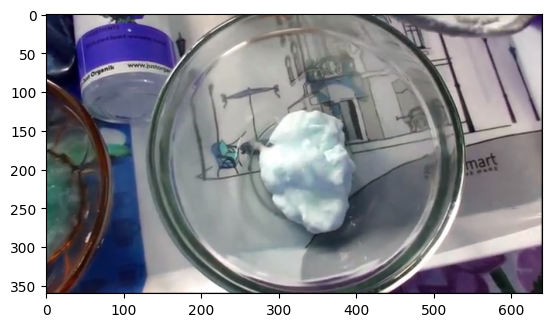

In [41]:
for element in PatchedSet: 
	print("Element dtyp: ", type(element))
	print("Element len: ", len(element))
	print("Element shape: ", element.shape)